# Предсказание временного ряда при помощи SARIMA


In [ ]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
series = pd.read_csv(
    "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_car_sales.csv",
    index_col=[0],
    parse_dates=[0]
    )
series.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


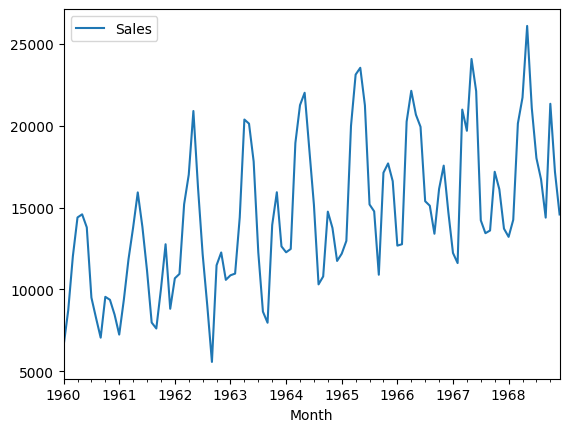

In [ ]:
series.plot();

Мы видим в ряде тренд и сезонность. Пока не будем обращать внимания на сезонность.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)

if result[1] > 0.05:
    print('Ряд нестационарный: ', result[1])

    series['stationary'] = series.diff()[1:]
    result = adfuller(series['stationary'][1:])
    print('Ряд после дифференцирования: ', result[1])
else:
    series['stationary'] = series['Sales']
    print('Ряд стационарный: ', result[1])

print()
print('ADF statistics: ', result[0])
print('p-value: ', result[1])

Ряд нестационарный:  0.6632691049832861
Ряд после дифференцирования:  5.8447525992768446e-08

ADF statistics:  -6.1997992308006955
p-value:  5.8447525992768446e-08


Мы видим, что одного дифференцирования достаточно, чтобы убрать тренд. Запомним это.

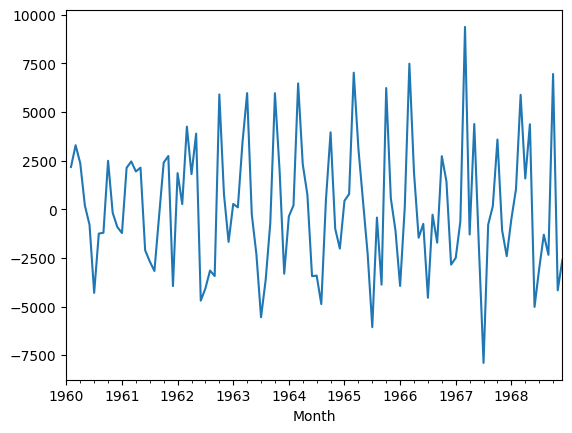

In [ ]:
series['stationary'].plot();

Разобъем данные на трейн и тест.

In [ ]:
train_length = int(len(series) * 0.9)

train = series[:train_length]
test = series[train_length:]

train.shape, test.shape

((97, 2), (11, 2))

## Подбор гиперпараметров SARIMAX

У модели SARIMAX есть два набора гиперпараметров:
* (p,d,q) - отвечают за тренд
* (P,D,Q,S) - отвечают за сезонность

По-хорошему, можно подбирать сразу все 7 гиперпараметров одновременно.

Подбирать можно двумя способами:
* Анализируя графики ACF и PACF
* Перебирая гиперпараметры и минимизируя AIC (или BIC, или RMSE)

Второй способ долгий, но испробуем его. Поэтому сначала для ускорения процесса будем считать, что сезонности у нас нет.

In [ ]:
p_values = range(0,12)
q_values = range(0,12)
# d_values =

In [ ]:
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in [1]:
        for q in q_values:
            order = (p,d,q)
            try:
                model = sm.tsa.statespace.SARIMAX(train['Sales'], order=order, enforce_invertibility=True, enforce_stationarity=True).fit()
                y_hat = model.predict(start = test.index[0], end = test.index[-1])

                if model.aic < best_score:
                    best_score, best_cfg = model.aic, order
                    print('SARIMAX%s AIC=%.3f' % (order, model.aic))
            except:
                continue
print('Best SARIMAX%s AIC=%.3f' % (best_cfg, best_score))

SARIMAX(0, 1, 0) AIC=1826.013
SARIMAX(0, 1, 1) AIC=1823.549
SARIMAX(0, 1, 3) AIC=1804.701
SARIMAX(0, 1, 4) AIC=1797.885
SARIMAX(0, 1, 6) AIC=1785.985
SARIMAX(1, 1, 5) AIC=1784.651
SARIMAX(2, 1, 7) AIC=1783.818
SARIMAX(5, 1, 9) AIC=1781.257
SARIMAX(5, 1, 11) AIC=1777.804
SARIMAX(6, 1, 2) AIC=1771.668
SARIMAX(6, 1, 4) AIC=1760.340
SARIMAX(6, 1, 5) AIC=1734.932
SARIMAX(11, 1, 5) AIC=1733.239
Best SARIMAX(11, 1, 5) AIC=1733.239


In [ ]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train['Sales'], order=(11,1,5)).fit()
model.aic

1733.239301260669

In [ ]:
y_hat = model.predict(start=len(train), end=(len(train)+len(test)-1))

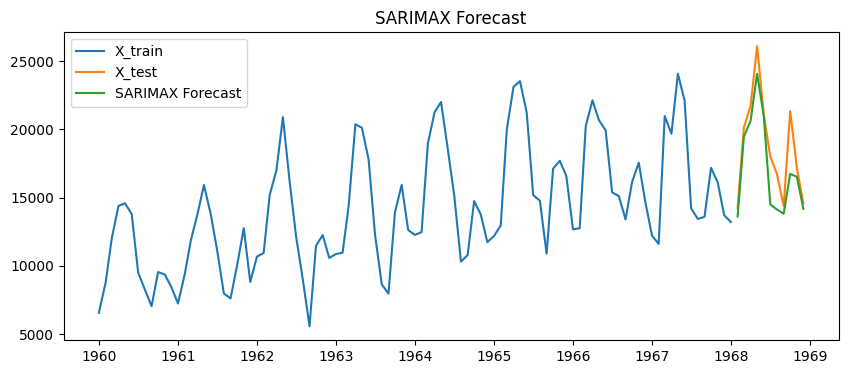

RMSE = 2073.822


In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train['Sales'].values, label='X_train')
plt.plot(test.index, test['Sales'].values, label='X_test')
plt.plot(test.index, y_hat, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX Forecast')
plt.show()
print('RMSE = %.3f' % mean_squared_error(test['Sales'], y_hat) ** 0.5)

Попробуем улучшить модель путем учета сезонности.

Хорошим подходом будет комбинация подходов:
* какие-то гиперпараметры можем посмотреть по графикам ACF и PACF
* какие-то найти перебором

Как определить сезонные гиперпараметры (P,D,Q,S) по графикам?

1) Построим графики ACF и PACF для ряда уже без тренда

2) Сезон S определяется по ACF визуально - это период, через который корреляции начнут себя примерно повторять

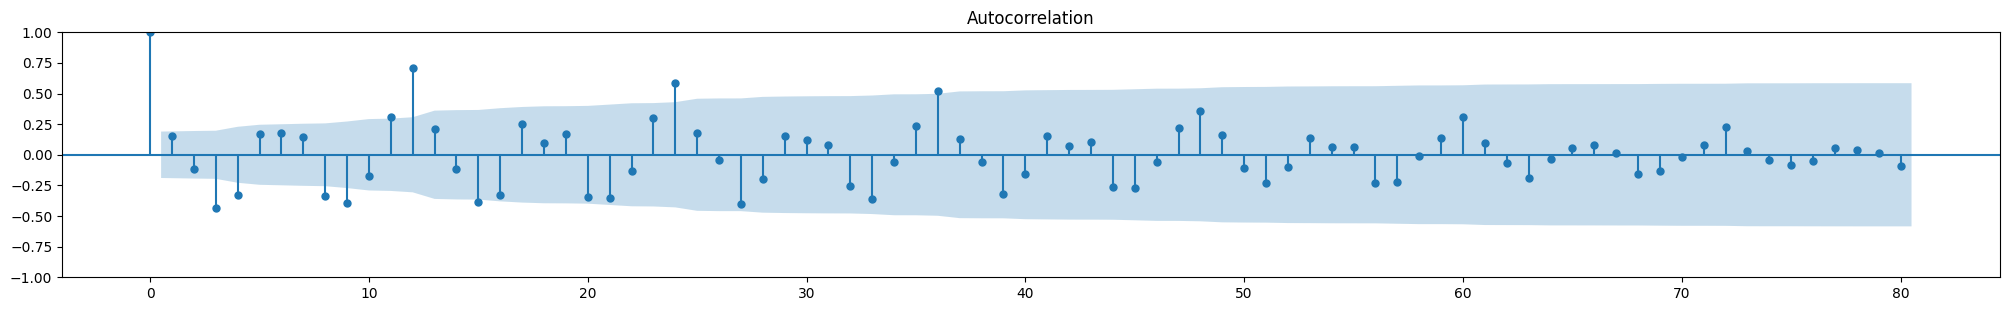

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series['stationary'][1:], lags=80, ax = ax1)

Получили S = 12

Чтобы определить P и Q, действуем аналогично подходу для определения p и q по графикам:

* P - число значимых пиков PACF в сезон (при сезоне S=12 анализируем столбцы с номерами 12, 24, 36 и так далее)
* Q - число значимых пиков ACF в сезон

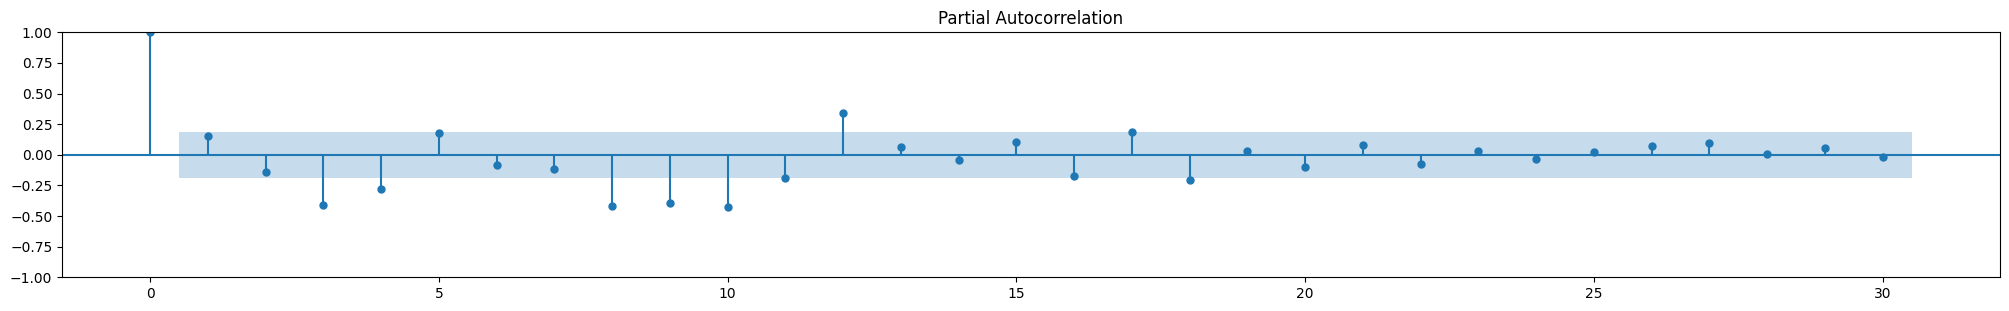

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(series['stationary'][1:], lags=30, ax = ax1)

Из графика PACF скорее всего следует, что P = 1

Из графика ACF скорее всего следует, что Q = 1, 2 или 3

Проверим нашу гипотезу. Будем считать RMSE для прогноза.

In [ ]:
P = 1
Q = 3

for P_try in range(P+1):
    for Q_try in range(Q+1):
        model = sm.tsa.statespace.SARIMAX(train['Sales'], order=(11,1,5), seasonal_order=(P_try, 0, Q_try, 12)).fit()
        y_hat = model.predict(start=len(train), end=(len(train)+len(test)-1))

        print('P = %.3f, Q = %.3f' % (P_try, Q_try))
        print('RMSE: ', mean_squared_error(test['Sales'], y_hat) ** 0.5)

P = 0.000, Q = 0.000
RMSE:  2073.8215955094875
P = 0.000, Q = 1.000
RMSE:  2408.810698794564
P = 0.000, Q = 2.000
RMSE:  3345.0965818381555
P = 0.000, Q = 3.000
RMSE:  2999.5358328707066
P = 1.000, Q = 0.000
RMSE:  2273.35259243319
P = 1.000, Q = 1.000
RMSE:  2496.2246723595576
P = 1.000, Q = 2.000
RMSE:  2773.5653170275295
P = 1.000, Q = 3.000
RMSE:  2520.9695966451886


In [ ]:
model = sm.tsa.statespace.SARIMAX(train['Sales'], order=(11,1,5), seasonal_order=(0,0,0,12)).fit()
model.aic

1733.239301260669

In [ ]:
y_hat = model.predict(start=len(train), end=(len(train)+len(test)-1))

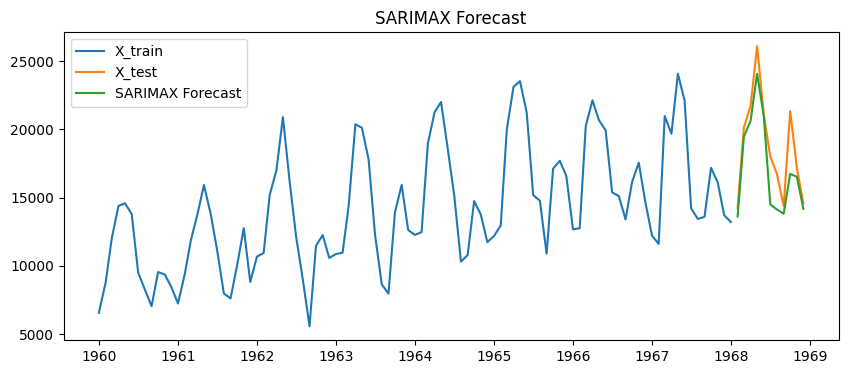

RMSE = 2073.822


In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train['Sales'].values, label='X_train')
plt.plot(test.index, test['Sales'].values, label='X_test')
plt.plot(test.index, y_hat, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX Forecast')
plt.show()
print('RMSE = %.3f' % mean_squared_error(test['Sales'], y_hat) ** 0.5)

## Важное замечание!

В этом ноутбуке мы делили данные только на train и test, но на самом деле когда мы обучаем модели и подбираем гиперпараметры, то нужно три разбиения:

* по train обучаем модель
* по val в цикле подбираем наилучшие гиперпараметры (здесь это был test)
* по test оцениваем качество наилучшей модели

По оси времени train < val < test.